In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *

indir1 = '/projects/ps-yeolab3/tao/CIRI/organoids/output'
circ_quant_output = [os.path.join(indir1,f) for f in os.listdir(indir1) if f.endswith('.gtf')]





In [2]:
circ_quant_output

['/projects/ps-yeolab3/tao/CIRI/organoids/output/CVB_STO.gtf',
 '/projects/ps-yeolab3/tao/CIRI/organoids/output/HT_109_STO_2.gtf',
 '/projects/ps-yeolab3/tao/CIRI/organoids/output/HT_109_CO.gtf',
 '/projects/ps-yeolab3/tao/CIRI/organoids/output/HT_109_STO_1.gtf']

In [3]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']

for fname in circ_quant_output:
    name = os.path.basename(fname).replace('.gtf', '')
    names.append(name)
    
    circ_df, stat = read_ciri_gtf(fname)
    
    circ_type_count.append(circ_df['circ_type'].value_counts())
    
    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))
    mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()

In [5]:
stats_df = pd.concat(stats, axis = 1).T

In [6]:
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

In [7]:
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

In [8]:
stats_df.sort_values('frac_circular')
stats_df.set_index('##Sample', inplace = True)

In [9]:
stats_df

,##Total_Reads,##Mapped_Reads,##Circular_Reads,##version,frac_circular,frac_mapped
##Sample,,,,,,
CVB_STO,43114176,34048824,1481110,1.1.2,0.043500,0.789736
HT_109_STO_2,54155286,43084588,1900920,1.1.2,0.044121,0.795575
HT_109_CO,44802982,35472926,1031860,1.1.2,0.029089,0.791754
HT_109_STO_1,64914456,52062410,2096628,1.1.2,0.040271,0.802016


In [10]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

In [11]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

In [12]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

In [13]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

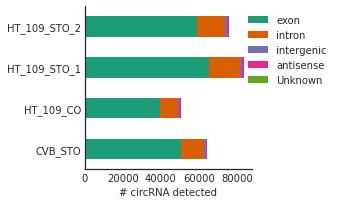

In [14]:
import matplotlib.pyplot as plt
counts.T.sort_index().plot.barh(stacked = True, figsize = (3,3))
plt.xlabel('# circRNA detected')
plt.legend(bbox_to_anchor = (1.5, 1))
sns.despine()
plt.savefig(figdir / '5_n_circles.pdf')

# Overlap between circular RNAs in cell line

In [15]:
circname = {}
for col in bsj.columns:
    circname[col]=set(bsj.loc[~bsj[col].isnull()].index)

Text(0.5, 1.0, 'organoid circles')

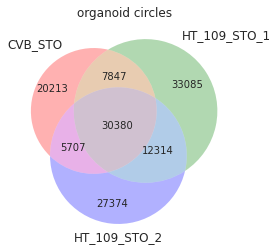

In [16]:
from matplotlib_venn import venn3
venn3([circname[p] for p in ['CVB_STO', 'HT_109_STO_1','HT_109_STO_2']]
      , set_labels = ('CVB_STO', 'HT_109_STO_1','HT_109_STO_2'), 
      
      alpha = 0.3
     )
plt.title('organoid circles')
#plt.savefig(figdir / '5_venn_3cellline.pdf')

Text(0.5, 1.0, 'organoid circles')

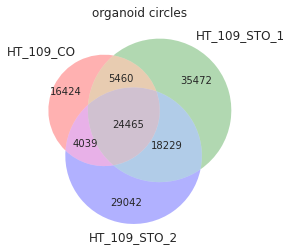

In [17]:
from matplotlib_venn import venn3
venn3([circname[p] for p in ['HT_109_CO', 'HT_109_STO_1','HT_109_STO_2']]
      , set_labels = ('HT_109_CO', 'HT_109_STO_1','HT_109_STO_2'), 
      
      alpha = 0.3
     )
plt.title('organoid circles')
#plt.savefig(figdir / '5_venn_3cellline.pdf')

<AxesSubplot: >

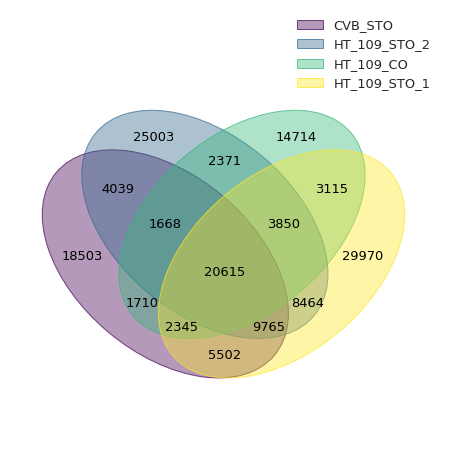

In [18]:
from venn import venn
venn(circname)


# Correlating CPM levels

In [19]:
cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


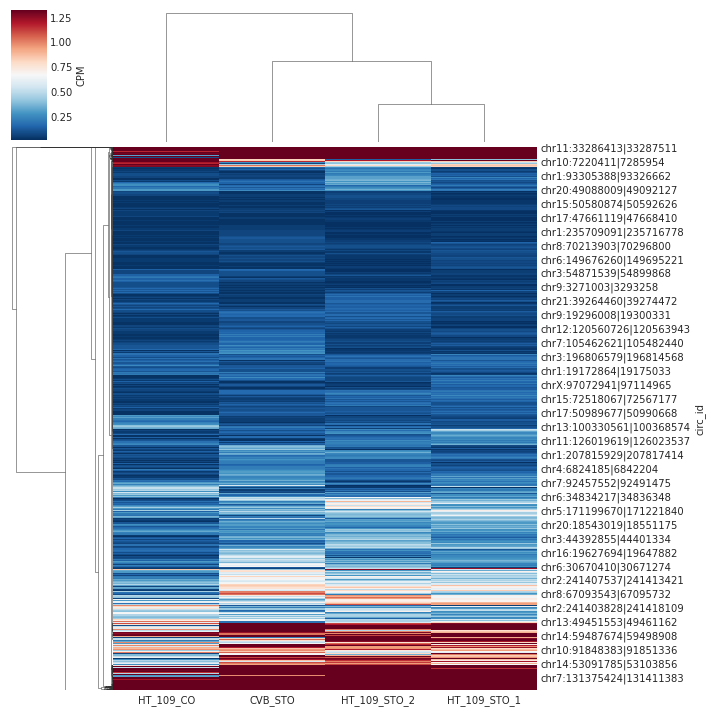

In [20]:
all_expressed = cpm.loc[cpm.isnull().sum(axis = 1)<1]
max_value = all_expressed.mean().median()
sns.clustermap(all_expressed, cmap = 'RdBu_r', vmax = max_value*2, 
              cbar_kws = {'label':'CPM'})
# plt.savefig(figdir / '5_cell_line_CPM_clust.pdf')

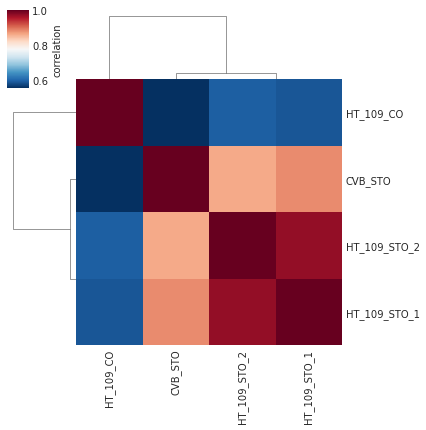

In [21]:
from scipy.spatial.distance import pdist, squareform
corr = pd.DataFrame(1-squareform(pdist(all_expressed.T, 'correlation')),
                    index = all_expressed.columns,
                    columns = all_expressed.columns)

sns.clustermap(corr, metric = 'correlation', cmap = 'RdBu_r', figsize = (6,6), cbar_kws = {'label': 'correlation'})
plt.savefig(figdir / '5_cell_line_CPM_corr.pdf')

# Differentially expressed circles

# Other analysis: what contributes to differentially expressed circles
- linear RNA expression: download from CCLE [here](https://www.ebi.ac.uk/gxa/experiments/E-MTAB-2770/Results)
- [link](https://www.ebi.ac.uk/gxa/experiments-content/E-MTAB-2770/resources/ExperimentDownloadSupplier.RnaSeqBaseline/fpkms.tsv)

- cell type specific casette exons?
- intron lengths

# The same gene express different circles?

In [22]:
mega_anno.loc[cpm.loc[cpm.isnull().sum(axis = 1)<3].index]['gene_name'].value_counts()

USP34         100
SMARCC1        93
BIRC6          92
PDS5A          92
ADGRB3         86
             ... 
DNAAF2          1
MAPK1IP1L       1
FBXO34          1
AL355834.2      1
IDH3G           1
Name: gene_name, Length: 10261, dtype: int64

In [23]:
coords = BedTool('/home/hsher/gencode_coords/gencode.v35.annotation.gff3')
from collections import defaultdict
exon_dict = defaultdict(lambda: list())
for c in coords:
    if c[2]=='exon':
        exon_dict[c.attrs['gene_name']].append([c.start, c.end])

In [24]:
def plot_bsj(gene):
    sub = cpm.loc[mega_anno.loc[mega_anno['gene_name']==gene].index]
    
    print(sub.shape)
    clines = sorted(list(sub.columns))
    max_cpm = sub.max().max()
    sub['start']=mega_anno['start']
    sub['end']=mega_anno['end']
    
    print(clines)
    f, ax = plt.subplots(1,int(len(clines)/2),  figsize = (int(3*len(clines)/2),3), sharex = True, sharey = True)
    for i,c in enumerate(clines): 
        if i%2==0:
            ax[i//2].scatter(sub['start'], sub['end'], (sub[c]/max_cpm)*10, label = c)
            ax[i//2].text(sub['start'].min(), sub['end'].max(), c)
        else:
            ax[i//2].scatter(sub['end'],sub['start'],  (sub[c]/max_cpm)*10, label = c)
            ax[i//2].text(sub['end'].max(), sub['start'].min(), c)
        ax[i//2].set_title(c.split('_')[0])
        
        
        
    sns.despine()
    
    # _ = [a.legend() for a in ax]
    _ = [a.set_ylabel('BSJ start/end') for a in ax]
    _ = [a.set_xlabel('BSJ start/end') for a in ax]
    
    min_ax = min([i[0] for i in exon_dict[gene]])
    max_ax = max([i[1] for i in exon_dict[gene]])
    # for a in ax:
    #     for exon in exon_dict[gene]:
    #         #print(exon, min_ax, max_ax)
    #         # if exon[0]>sub['start'].min():
    #         a.plot([min_ax]*2, exon, linewidth=7.0, color = 'lightgrey')
    #         a.plot(exon, [min_ax]*2,  linewidth=7.0, color = 'lightgrey')
    #         a.axhspan(exon[0], exon[1], xmin=min_ax, xmax=max_ax, color = 'lightgrey')
    #         a.axvspan(exon[0], exon[1], ymin=min_ax, ymax=max_ax, color = 'lightgrey')
            
    _ = [a.plot([min_ax, max_ax], [min_ax, max_ax], '--', color = 'black') for a in ax]
    
    plt.suptitle(gene)

(151, 4)
['CVB_STO', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2']


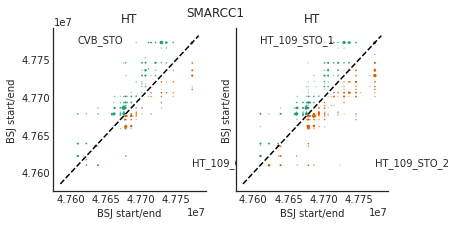

In [25]:
plot_bsj('SMARCC1')
#plt.savefig(figdir / '5_BSJ_in_SMARCC1.pdf')

(111, 4)
['CVB_STO', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2']


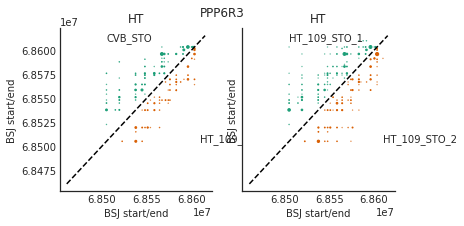

In [26]:
plot_bsj('PPP6R3')


(195, 4)
['CVB_STO', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2']


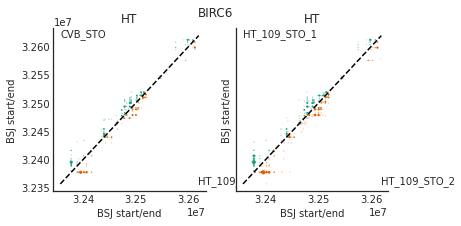

In [27]:
plot_bsj('BIRC6')

(157, 4)
['CVB_STO', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2']


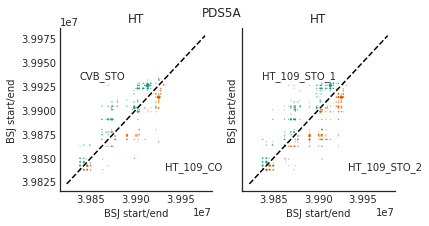

In [28]:
plot_bsj('PDS5A')


(224, 4)
['CVB_STO', 'HT_109_CO', 'HT_109_STO_1', 'HT_109_STO_2']


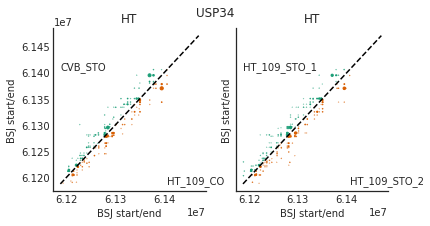

In [29]:
plot_bsj('USP34')


# Differential expression analysis

In [36]:
de_path = Path('/projects/ps-yeolab5/hsher/Tao_circ_huntington/output/unadjusted_comparison')

de_dict = {}
for f in de_path.glob('*gtf.tsv'):
    df = pd.read_csv(f, sep = '\t', index_col = 0)
    
    df = df.merge(mega_anno, left_index = True, right_index = True)
    de_dict[f.name.replace('.gtf.tsv', '')] = df

In [43]:
merged_de = de_dict['CVB_STO.HT_109_STO_1'].merge(
    de_dict['CVB_STO.HT_109_STO_2'], left_index = True,
right_index = True, suffixes = ('_rep1', '_rep2')
)

In [50]:
merged_de.loc[(merged_de['DE_score_rep2']>0)&(merged_de['DE_score_rep1']>0)].shape,merged_de.loc[(merged_de['DE_score_rep2']<0)&(merged_de['DE_score_rep1']<0)].shape

((2078, 32), (4294, 32))

<AxesSubplot: xlabel='DE_score_rep2', ylabel='DE_score_rep1'>

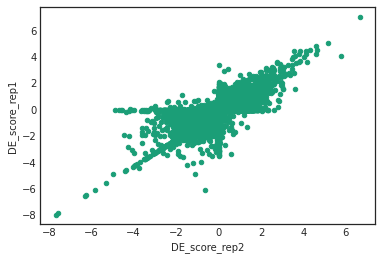

In [52]:
merged_de.plot.scatter(x = 'DE_score_rep2', y = 'DE_score_rep1')

In [54]:
merged_de.to_csv(figdir / 'huntington_de_circ.csv')